In [1]:

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

2.0.0+cpu


  ERROR: Command errored out with exit status 1:
   command: 'E:\Anaconda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\D E L L\\AppData\\Local\\Temp\\pip-install-durzj4fy\\torch-scatter_68b3669a2f17449f85df3ccfcd562035\\setup.py'"'"'; __file__='"'"'C:\\Users\\D E L L\\AppData\\Local\\Temp\\pip-install-durzj4fy\\torch-scatter_68b3669a2f17449f85df3ccfcd562035\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\D E L L\AppData\Local\Temp\pip-wheel-ri46a6m2'
       cwd: C:\Users\D E L L\AppData\Local\Temp\pip-install-durzj4fy\torch-scatter_68b3669a2f17449f85df3ccfcd562035\
  Complete output (38 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-am

  copying torch_sparse\masked_select.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\matmul.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\metis.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\mul.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\narrow.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\permute.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\reduce.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\rw.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\saint.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\sample.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\select.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\spadd.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\spmm.py -> build\lib.win-amd64-3.9\torch_sparse
  copying torch_sparse\spspmm.py -> build\lib.win-amd64

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  

print()
print(data)
print('===========================================================================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [5]:
from IPython.display import Javascript  
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  
      optimizer.step()  
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [6]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


In [7]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


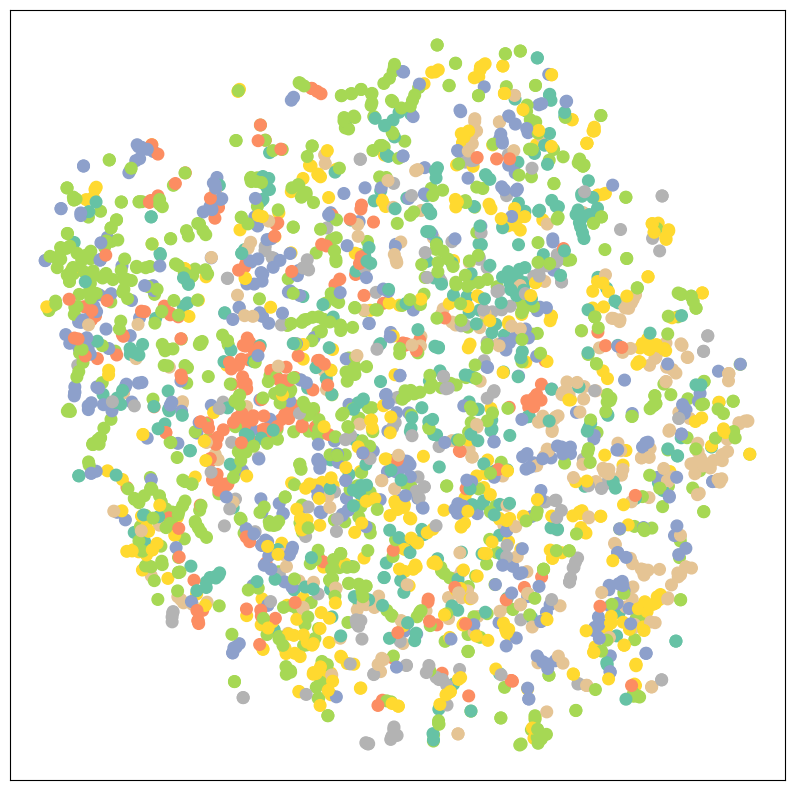

In [8]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask]) 
      loss.backward()  
      optimizer.step()  
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1) 
      test_correct = pred[data.test_mask] == data.y[data.test_mask] 
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) 
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


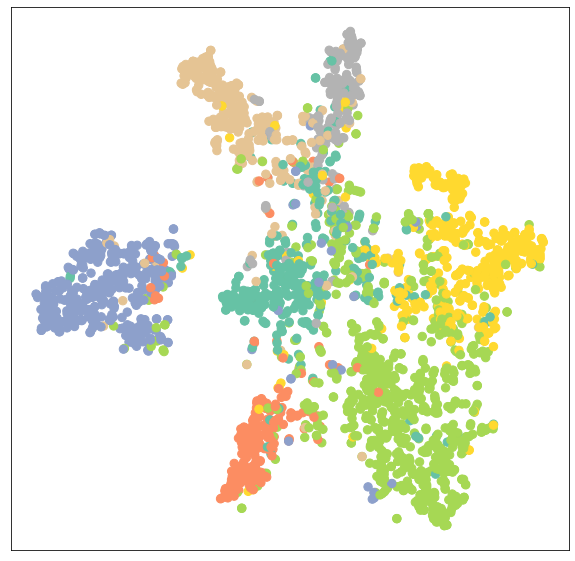

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [11]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads,num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_channels=data.num_features, out_channels=hidden_channels, heads=heads, dropout=0.6)  
        self.conv2 = GATConv(in_channels=hidden_channels*heads, out_channels= num_classes, heads=1, dropout=0.6)  

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8,num_classes=7)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x, data.edge_index)  
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step() 
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  
      correct = pred[mask] == data.y[mask] 
      acc = int(correct.sum()) / int(mask.sum())  
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9436, Val: 0.1980, Test: 0.2190
Epoch: 002, Loss: 1.9379, Val: 0.3280, Test: 0.3200
Epoch: 003, Loss: 1.9304, Val: 0.2780, Test: 0.2700
Epoch: 004, Loss: 1.9294, Val: 0.3200, Test: 0.3230
Epoch: 005, Loss: 1.9171, Val: 0.4920, Test: 0.4860
Epoch: 006, Loss: 1.9171, Val: 0.6240, Test: 0.6190
Epoch: 007, Loss: 1.9025, Val: 0.7160, Test: 0.7180
Epoch: 008, Loss: 1.8928, Val: 0.7300, Test: 0.7430
Epoch: 009, Loss: 1.8860, Val: 0.7320, Test: 0.7380
Epoch: 010, Loss: 1.8871, Val: 0.7500, Test: 0.7500
Epoch: 011, Loss: 1.8792, Val: 0.7600, Test: 0.7670
Epoch: 012, Loss: 1.8676, Val: 0.7580, Test: 0.7760
Epoch: 013, Loss: 1.8559, Val: 0.7520, Test: 0.7570
Epoch: 014, Loss: 1.8643, Val: 0.7400, Test: 0.7380
Epoch: 015, Loss: 1.8262, Val: 0.7300, Test: 0.7280
Epoch: 016, Loss: 1.8264, Val: 0.7300, Test: 0.7250
Epoch: 017, Loss: 1.8133, Val: 0.7300, Test: 0.7280
Epoch: 018, Loss: 1.8296, Val: 0.7280

In [13]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8280


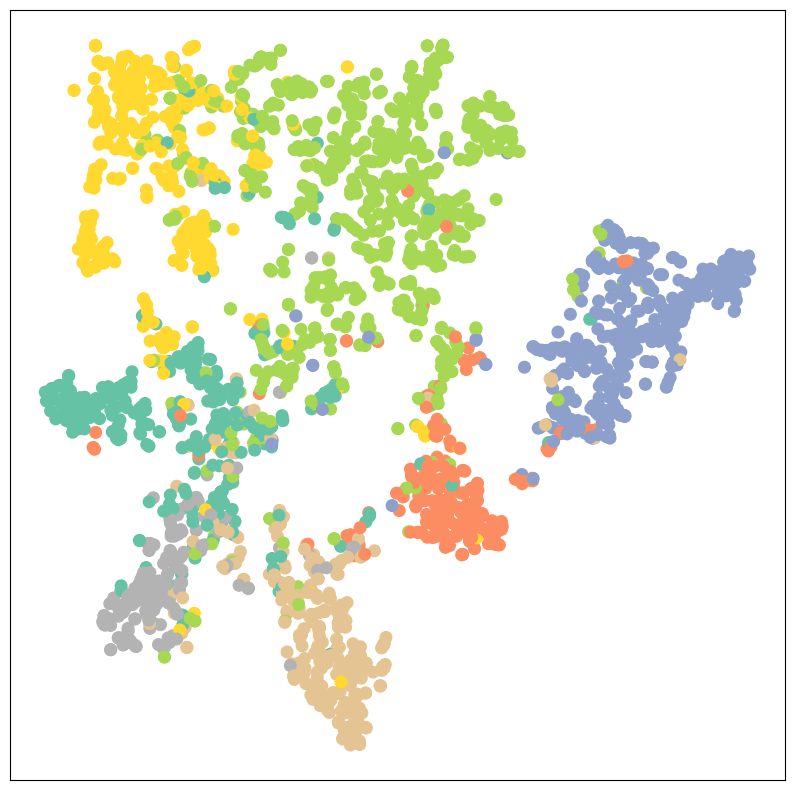

In [14]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)